In [40]:
import numpy as np
from numpy import matlib
import mne
import pandas as pd
import pyedflib
import seaborn as sns
from swlda import SWLDA
from pyedflib import highlevel
from datetime import datetime
from mne.decoding import CSP

In [2]:
board = [["A",    "B",  "C",   "D",    "E",    "F",     "G",    "H"],
         ["I",    "J",  "H",   "L",    "M",    "N",     "O",    "P"],
         ["Q",    "R",  "S",   "T",    "U",    "V",     "W",    "X"],
         ["Y",    "Z",  "Sp",  "1",    "2",    "3",     "4",    "5"],
         ["6",    "7",  "8",   "9",    "0",    ".",     "RET",  "BS"],
         ["CTRL", "=",  "DEL", "HOME", "UPAW", "END",   "PGUP", "SHIFT"],
         ["SAVE", "'",  "F2",  "LFAW", "DNAW", "RTAW",  "PGON", "PAUSE"],
         ["CAPS", "F5", "TAB", "EC",   "ESC",  "EMAIL", "!",    "SLEEP"]]


def RCIndexConveter(board, index: int) -> str:
    """
    Convert index on the board to the character.

    Parameters:
        - board (2d list of str): a rectangle board to display characters.
        - index: the index on each location

    Returns:
        the character corresponding to the given index.
    """
    num_rows = len(board)
    num_cols = len(board[0])
    r = (index - 1) // num_cols
    c = (index - 1) %  num_cols
    return board[r][c]

In [3]:
filename = '../data/RC/Train/A01_SE001RC_Train01.edf'
raw_data = mne.io.read_raw_edf(filename, verbose=False) # read data
raw_data.load_data() # load data
eeg_channels = mne.pick_channels_regexp(raw_data.info['ch_names'], 'EEG')
raw_data.notch_filter(freqs=60, picks=eeg_channels)

Reading 0 ... 34983  =      0.000 ...   136.652 secs...
Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 59 - 61 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation


- Lower passband edge: 59.35
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 59.10 Hz)
- Upper passband edge: 60.65 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 60.90 Hz)
- Filter length: 1691 samples (6.605 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  32 out of  32 | elapsed:    0.0s finished


<RawEDF | A01_SE001RC_Train01.edf, 114 x 34984 (136.7 s), ~30.5 MB, data loaded>

In [4]:
raw_data.info['ch_names'][-10:-1]

['StimulusType',
 'SelectedTarget',
 'SelectedRow',
 'SelectedColumn',
 'PhaseInSequence',
 'StimulusBegin',
 'StimulusCode',
 'CurrentTarget',
 'FakeFeedback']

In [5]:
current_target_events   = mne.find_events(raw_data, stim_channel='CurrentTarget',
                                          verbose=False)
current_target   = current_target_events[:,2] # event ids
current_target

array([ 4, 18,  9, 22,  9, 14,  7])

In [6]:
# Find stimulus events and target stimulus events.
# Non zero value in `StimulusBegin` indicates stimulus onset.
stim_events     = mne.find_events(raw=raw_data, stim_channel='StimulusBegin',
                                  verbose=False)
# Non zero value in `StimulusType` if is target stimulus event.
targstim_events = mne.find_events(raw=raw_data, stim_channel='StimulusType',
                                  verbose=False)

# Label target and non-target events.
# Note that the event_id is stored in the third column in events array.
targstim_indices = np.isin(stim_events[:,0], targstim_events[:,0])
stim_events[targstim_indices,2]  = 1 # label target events as 1
stim_events[~targstim_indices,2] = 0 # label non-target events as 0

# Epoch data based on target and non-target epoch labels.
t_min,t_max = 0, 0.8 # feature extraction window
event_dict = {'target': 1, 'non_target': 0} # stimulus event label -> event_id
epochs = mne.Epochs(raw=raw_data, events=stim_events, tmin=t_min, tmax=t_max,
                    event_id=event_dict, preload=True, baseline=None,
                    proj=False, picks=eeg_channels)

Not setting metadata
833 matching events found
No baseline correction applied
Using data from preloaded Raw for 833 events and 206 original time points ...
0 bad epochs dropped


In [7]:
epochs.info

<Info | 7 non-empty values
 bads: []
 ch_names: EEG_F3, EEG_Fz, EEG_F4, EEG_T7, EEG_C3, EEG_Cz, EEG_C4, EEG_T8, ...
 chs: 32 EEG
 custom_ref_applied: False
 highpass: 0.5 Hz
 lowpass: 30.0 Hz
 meas_date: 2020-01-01 00:00:00 UTC
 nchan: 32
 projs: []
 sfreq: 256.0 Hz
>

Not setting metadata
98 matching events found
No baseline correction applied
0 projection items activated


/var/folders/q5/lmwck4v56_bbv_rr256g0bpr0000gn/T/ipykernel_876/1931909291.py:3: RuntimeWarning: Cannot find channel coordinates in the supplied Evokeds. Not showing channel locations.
  epochs['target'].plot_image(picks=channel_pick,


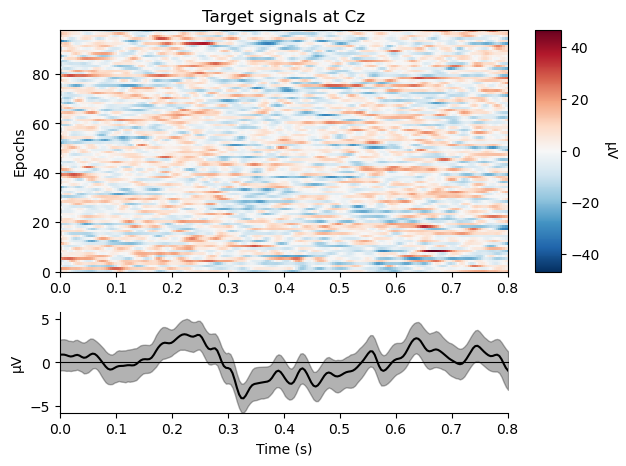

[<Figure size 640x480 with 3 Axes>]

In [8]:
channel_pick = raw_data.ch_names[5] # EEG_CZ
# Plot target signals at a specific channel
epochs['target'].plot_image(picks=channel_pick,
                            title='Target signals at '+channel_pick[4:])

Not setting metadata
735 matching events found
No baseline correction applied
0 projection items activated


/var/folders/q5/lmwck4v56_bbv_rr256g0bpr0000gn/T/ipykernel_876/3887258469.py:2: RuntimeWarning: Cannot find channel coordinates in the supplied Evokeds. Not showing channel locations.
  epochs['non_target'].plot_image(picks=channel_pick,


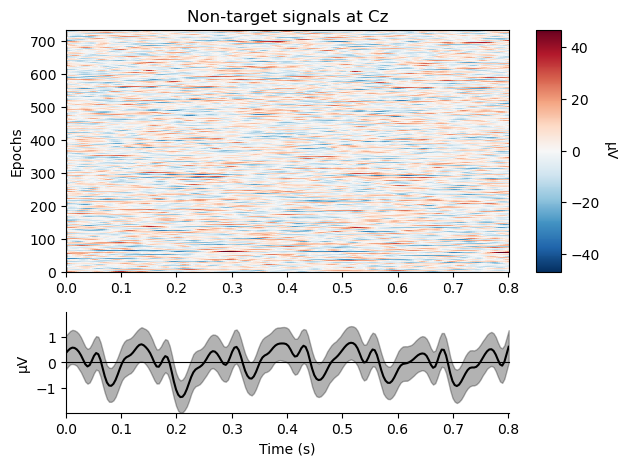

[<Figure size 640x480 with 3 Axes>]

In [9]:
# Plot non-target signals at a specific channel
epochs['non_target'].plot_image(picks=channel_pick,
                                title='Non-target signals at '+channel_pick[4:])

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


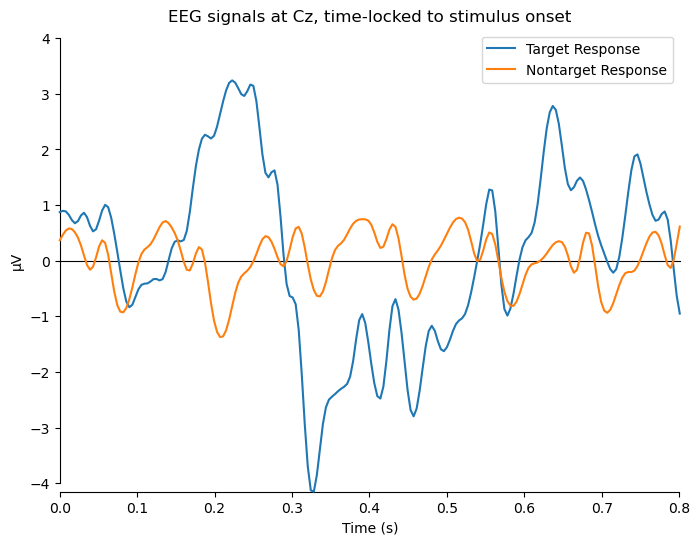

[<Figure size 800x600 with 1 Axes>]

In [10]:
# Average target and nontarget signals
erp_target = epochs['target'].average()
erp_nontarget = epochs['non_target'].average()
figure_title = 'EEG signals at '+channel_pick[4:]+', time-locked to stimulus onset'
mne.viz.plot_compare_evokeds(evokeds={'Target Response': erp_target,
                                      'Nontarget Response': erp_nontarget},
                             picks=channel_pick,
                             show_sensors=False,
                             title=figure_title,
                             legend=1)

In [11]:
core_channel_names = ('EEG_Fz',  'EEG_Cz',  'EEG_P3', 'EEG_Pz', 'EEG_P4',
                      'EEG_PO7', 'EEG_PO8', 'EEG_Oz')
core_eeg_channels = mne.pick_channels(raw_data.info['ch_names'],
                                      core_channel_names)
core_epochs = mne.Epochs(raw=raw_data, events=stim_events, tmin=t_min, tmax=t_max,
                         event_id=event_dict, preload=True, baseline=None,
                         proj=False, picks=core_eeg_channels)

Not setting metadata
833 matching events found
No baseline correction applied
Using data from preloaded Raw for 833 events and 206 original time points ...
0 bad epochs dropped


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
combining channels using "mean"
combining channels using "mean"


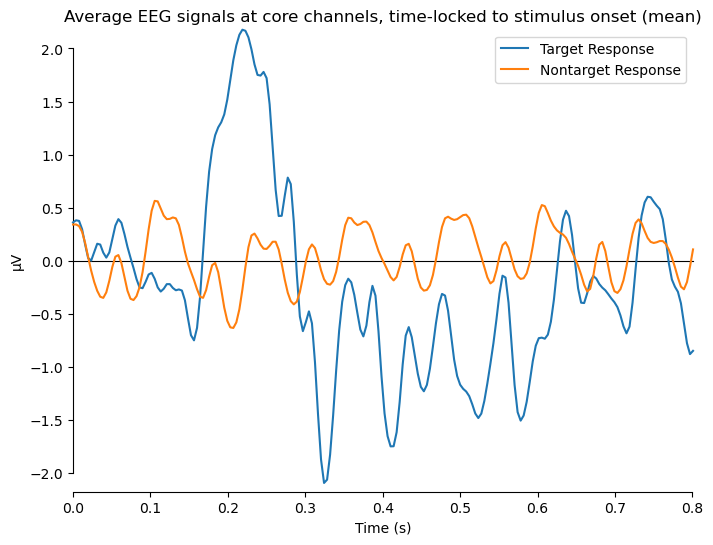

[<Figure size 800x600 with 1 Axes>]

In [12]:
# Average target and nontarget signals
erp_target = core_epochs['target'].average()
erp_nontarget = core_epochs['non_target'].average()
figure_title = 'Average EEG signals at core channels, time-locked to stimulus onset'
mne.viz.plot_compare_evokeds(evokeds={'Target Response': erp_target,
                                      'Nontarget Response': erp_nontarget},
                             combine='mean',
                             show_sensors=False,
                             title=figure_title,
                             legend=1)

In [13]:
def blockwise_average_3D(A,S):
    # A is the 3D input array
    # S is the blocksize on which averaging is to be performed

    m,n,r = np.array(A.shape)//S
    return A.reshape(m,S[0],n,S[1],r,S[2]).mean((1,3,5))

In [14]:
raw_target_set = core_epochs['target'].get_data()
print('In the target set, we have:')
print(f'Number of samples = {raw_target_set.shape[0]}')
print(f'Number of channels = {raw_target_set.shape[1]}')
print(f'Number of timestamps in each sample = {raw_target_set.shape[2]}')

In the target set, we have:
Number of samples = 98
Number of channels = 8
Number of timestamps in each sample = 206


In [15]:
raw_target_set = raw_target_set[:,:,:195]
downsampled_target_set = blockwise_average_3D(raw_target_set, (1, 1, 13))
target_set = downsampled_target_set.reshape(-1, 15)

In [16]:
raw_non_target_set = core_epochs['non_target'].get_data()
print('In the non-target set, we have:')
print(f'Number of samples = {raw_non_target_set.shape[0]}')
print(f'Number of channels = {raw_non_target_set.shape[1]}')
print(f'Number of timestamps in each sample = {raw_non_target_set.shape[2]}')

In the non-target set, we have:
Number of samples = 735
Number of channels = 8
Number of timestamps in each sample = 206


In [17]:
raw_non_target_set = raw_non_target_set[:,:,:195]
downsampled_non_target_set = blockwise_average_3D(raw_non_target_set, (1, 1, 13))
non_target_set = downsampled_non_target_set.reshape(-1, 15)

In [18]:
train_features = np.concatenate((target_set, non_target_set), axis=0)
target_response = np.ones(target_set.shape[0])
non_target_response = np.zeros(non_target_set.shape[0])
train_response = np.concatenate((target_response, non_target_response), axis=0)

In [19]:
def get_core_epochs(filename):
    filename = '../data/RC/Train/A01_SE001RC_Train01.edf'
    raw_data = mne.io.read_raw_edf(filename, verbose=False) # read data
    raw_data.load_data() # load data
    eeg_channels = mne.pick_channels_regexp(raw_data.info['ch_names'], 'EEG')
    raw_data.notch_filter(freqs=60, picks=eeg_channels)

    # Find stimulus events and target stimulus events.
    # Non zero value in `StimulusBegin` indicates stimulus onset.
    stim_events     = mne.find_events(raw=raw_data, stim_channel='StimulusBegin',
                                    verbose=False)
    # Non zero value in `StimulusType` if is target stimulus event.
    targstim_events = mne.find_events(raw=raw_data, stim_channel='StimulusType',
                                    verbose=False)

    # Label target and non-target events.
    # Note that the event_id is stored in the third column in events array.
    targstim_indices = np.isin(stim_events[:,0], targstim_events[:,0])
    stim_events[targstim_indices,2]  = 1 # label target events as 1
    stim_events[~targstim_indices,2] = 0 # label non-target events as 0

    # Epoch data based on target and non-target epoch labels.
    t_min,t_max = 0, 0.8 # feature extraction window
    event_dict = {'target': 1, 'non_target': 0} # stimulus event label -> event_id
    epochs = mne.Epochs(raw=raw_data, events=stim_events, tmin=t_min, tmax=t_max,
                        event_id=event_dict, preload=True, baseline=None,
                        proj=False, picks=eeg_channels)

    core_channel_names = ('EEG_Fz',  'EEG_Cz',  'EEG_P3', 'EEG_Pz', 'EEG_P4',
                        'EEG_PO7', 'EEG_PO8', 'EEG_Oz')
    core_eeg_channels = mne.pick_channels(raw_data.info['ch_names'],
                                        core_channel_names)
    core_epochs = mne.Epochs(raw=raw_data, events=stim_events, tmin=t_min, tmax=t_max,
                            event_id=event_dict, preload=True, baseline=None,
                            proj=False, picks=core_eeg_channels)
    return core_epochs

In [20]:
test_file = '../data/RC/Test/A01_SE001RC_Test06.edf'
test_epochs = get_core_epochs(test_file)

Reading 0 ... 34983  =      0.000 ...   136.652 secs...
Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 59 - 61 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 59.35
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 59.10 Hz)
- Upper passband edge: 60.65 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 60.90 Hz)
- Filter length: 1691 samples (6.605 s)

Not setting metadata
833 matching events found
No baseline correction applied
Using data from preloaded Raw for 833 events and 206 original time points ...
0 bad epochs dropped
Not setting metadata
833 matching events found
No baseline correction applied
Using data from preloaded Raw for 833 events and 206 original time points ...
0 bad epochs dropped


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  32 out of  32 | elapsed:    0.0s finished


In [21]:
raw_target_set = test_epochs['target'].get_data()
raw_target_set = raw_target_set[:,:,:195]
downsampled_target_set = blockwise_average_3D(raw_target_set, (1, 1, 13))
target_set = downsampled_target_set.reshape(-1, 15)

raw_non_target_set = test_epochs['non_target'].get_data()
raw_non_target_set = raw_non_target_set[:,:,:195]
downsampled_non_target_set = blockwise_average_3D(raw_non_target_set, (1, 1, 13))
non_target_set = downsampled_non_target_set.reshape(-1, 15)

test_num_targets = target_set.shape[0]
test_num_non_targets = non_target_set.shape[0]

test_features = np.concatenate((target_set, non_target_set), axis=0)
target_response = np.ones(target_set.shape[0])
non_target_response = np.zeros(non_target_set.shape[0])
test_response = np.concatenate((target_response, non_target_response), axis=0)

In [22]:
clf = SWLDA(penter=0.1, premove=0.15)
clf.fit(train_features, train_response)

In [29]:
scores = pd.DataFrame(clf.test(test_features), columns=['score'])

In [33]:
scores['is_target'] = test_response.astype('int')

<AxesSubplot: xlabel='score', ylabel='Density'>

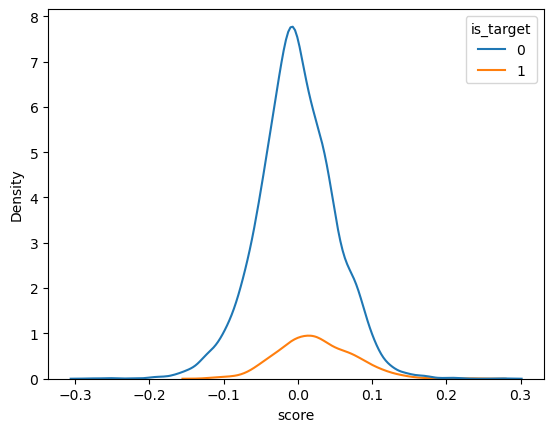

In [37]:
sns.kdeplot(data=scores, x='score', hue='is_target')

<AxesSubplot: xlabel='score', ylabel='Density'>

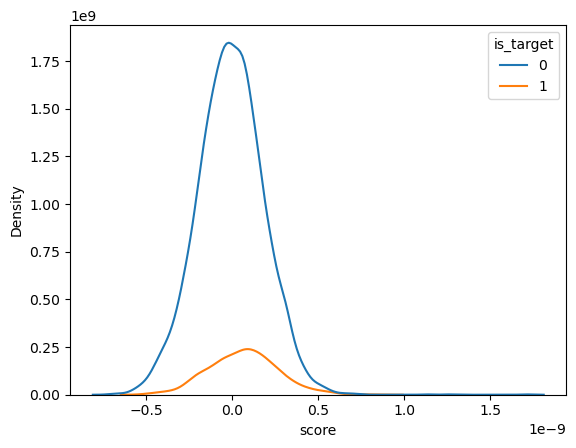

In [60]:
from sklearn.linear_model import LogisticRegression

lgt_clf = LogisticRegression()
lgt_clf.fit(X=train_features, y=train_response)
lgt_scores = np.dot(test_features, lgt_clf.coef_.T)
lgt_scores = pd.DataFrame(lgt_scores, columns=['score'])
lgt_scores['is_target'] = test_response.astype('int')
sns.kdeplot(data=lgt_scores, x='score', hue='is_target')

In [56]:
lgt_scores

array([[0.88235294, 0.11764706],
       [0.88235294, 0.11764706],
       [0.88235294, 0.11764706],
       ...,
       [0.88235294, 0.11764706],
       [0.88235294, 0.11764706],
       [0.88235294, 0.11764706]])